In [1]:
import os
import numpy as np
import glob
import time
import PIL.Image as Image
from tqdm.notebook import tqdm
from itertools import chain
from collections import OrderedDict


import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pylab as plt
import ipywidgets
from IPython import display

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [3]:
if not os.path.exists('./horse2zebra'):
  #import gdown
  #url = 'https://drive.google.com/uc?id=1jPelB2jzNZJq3ZU9Uk_Mkt4MJtF3DRgg'
  #gdown.download(url, './horse2zebra.zip', quiet=False)
  !wget https://courses.compute.dtu.dk/02514/project_data/horse2zebra.zip
  !unzip ./horse2zebra.zip > /dev/null

--2021-10-13 10:19:10--  https://courses.compute.dtu.dk/02514/project_data/horse2zebra.zip
Resolving courses.compute.dtu.dk (courses.compute.dtu.dk)... 130.225.68.6
Connecting to courses.compute.dtu.dk (courses.compute.dtu.dk)|130.225.68.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116683637 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip      35%[======>             ]  39.16M   446KB/s    eta 2m 38s ^C
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of ./horse2zebra.zip or
        ./horse2zebra.zip.zip, and cannot find ./horse2zebra.zip.ZIP, period.


In [ ]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


# Image extract

In [ ]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__ (self, state, path = "horse2zebra/", inception = False):
    self.image_A = sorted(glob.glob(os.path.join(path, state, "A", "*.jpg"))) # os.path.join: assemble path
                                                                              # glob.glob : return a list containing all the path of required file 
    self.image_B = sorted(glob.glob(os.path.join(path, state, "B", "*.jpg")))
    self.inception = inception

  def transform_(self, imageA, imageB):
    if imageA.mode != "RGB":
      imageA = imageA.convert("RGB")      # transform to RGB
    if imageB.mode != "RGB":
      imageB = imageB.convert("RGB")

    imageA = TF.resize(imageA, 128)
    imageB = TF.resize(imageB, 128)

    imageA = TF.to_tensor(imageA)
    imageB = TF.to_tensor(imageB)

    if self.inception:
        imageA = TF.normalize(imageA, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        imageB = TF.normalize(imageB, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    else:
        imageA = TF.normalize(imageA, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))     # Normalize image between [-1,1]
        imageB = TF.normalize(imageB, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    return imageA, imageB

  def __len__(self):
    return min(len(self.image_A), len(self.image_B))       # solve the problem of different number of images in two folders

  def __getitem__(self, idx):
    img_A = Image.open(self.image_A[idx])
    img_B = Image.open(self.image_B[idx])
    img_A, img_B = self.transform_(img_A, img_B)
    return img_A, img_B


In [ ]:
batch_size = 1
trainset = ImageDataset(state = "train")
#trainset_i = ImageDataset(state = "train", inception = True)
print("Number of training samples are ", len(trainset))
train_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 3)
#train_loader_i = DataLoader(trainset_i, batch_size = batch_size, shuffle = True, num_workers = 3)

testset = ImageDataset(state = "test")
#testset_i = ImageDataset(state = "train", inception = True)
print("Number of test samples are", len(testset))
test_loader = DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers = 3)
#test_loader_i = DataLoader(testset_i, batch_size = batch_size, shuffle = True, num_workers = 3)


Number of training samples are  1067
Number of test samples are 120


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Generator

In [ ]:
norm_layer = nn.InstanceNorm2d         # InstanceNorm2d is used for only one image,  batchNorm is used for batch image
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))      # resnet combines output and input(idential)

class Generator(nn.Module):
    def __init__(self, f=64, blocks=6):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([ #Uses a subpixel convolution (PixelShuffle) for upsamling 
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

# Discriminator

In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self, f=64):
#         super(Discriminator, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels = 3, out_channels = f, kernel_size = 4, stride = 2, padding = 1), # -> 128x128
#             nn.LeakyReLU(0.2, True),
#             nn.Conv2d(in_channels = f, out_channels = f*2, kernel_size = 4, stride = 2, padding = 1), # -> 64x64
#             nn.InstanceNorm2d(f*2),
#             nn.LeakyReLU(0.2, True),
#             nn.Conv2d(in_channels = f*2, out_channels = f*4, kernel_size = 4, stride = 2, padding = 1), # -> 32x32
#             nn.InstanceNorm2d(f*4),
#             nn.LeakyReLU(0.2, True),
#             nn.Conv2d(in_channels = f*4, out_channels = f*8, kernel_size = 4, stride = 1, padding = 1), # -> 31x31
#             nn.InstanceNorm2d(f*8),
#             nn.LeakyReLU(0.2, True),
#             nn.Conv2d(in_channels = f*8, out_channels = 1, kernel_size = 4, stride = 1, padding = 1), # -> 30x30
#             )
#     def forward(self, x):
#         return self.conv(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, f = 64):
    super(Discriminator, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, f, 4, stride = 2, padding = 1),     # 128*128 -> 64*64
        nn.InstanceNorm2d(f),
        nn.LeakyReLU(),

        nn.Conv2d(f, 2*f, 3, stride = 2, padding = 1),   # 64*64 -> 32
        nn.InstanceNorm2d(2*f),
        nn.LeakyReLU(),

        nn.Conv2d(2*f, 4*f, 4, stride = 2, padding = 1), # 32*32 -> 16*16
        nn.InstanceNorm2d(4*f),
        nn.LeakyReLU(),

        nn.Conv2d(4*f, 8*f, 3, stride = 1, padding = 0), # 16*16 -> 14*14
        nn.InstanceNorm2d(8*f),
        nn.LeakyReLU(),

        nn.Conv2d(8*f, 4*f, 3, stride = 1, padding = 0), # 14*14 -> 12*12
        nn.InstanceNorm2d(4*f),
        nn.LeakyReLU(),

        nn.Conv2d(4*f, 1, 3, stride = 1, padding = 1)    # 12*12 -> 12*12
    )

  def forward(self, x):
    #x = x.view(x.size(0), -1)
    x = self.conv(x)
    return x

# Loss Function

In [ ]:
# # Normal Gan
# def cyclic_loss(x_fake, x_real):
#     return torch.mean(torch.abs(x_real - x_fake))

# def identity_loss(x_fake, x_real):
#     return torch.mean(torch.abs(x_real - x_fake))

# def D_gan_loss(x_fake, x_real):
#     return -torch.mean(F.logsigmoid(x_real) + F.logsigmoid(1-x_fake))

# def G_gan_loss(x_fake):
#     return -torch.mean(F.logsigmoid(x_fake))

In [ ]:
# LSGAN
def D_true_loss(x_real):
  return torch.mean((x_real - 1)**2)

def D_false_loss(x_fake):
  return torch.mean(x_fake**2)

def G_true_loss(x_fake):
  return 0.5 * torch.mean((x_fake - 1) ** 2)

def cyclic_loss(x_return, x_real):
  return torch.mean(torch.abs(x_return - x_real))

def identity_loss(x_construction, x_real):
  return torch.mean(torch.abs(x_construction - x_real))

# Train

## Normal Gan

In [ ]:
# # Normal Gan
# def train(D_h, D_z, G_h2z, G_z2h, d_opt, g_opt, num_epoch = 10):
#   out_dict = {
#               "D_h_loss" : [],
#               "D_z_loss" : [],
#               "D_loss" : [],
#               "G_h2z_true_loss" : [],
#               "G_h2z_cyclic_loss" : [],
#               "G_h2z_identity_loss" : [],
#               "G_z2h_true_loss" : [],
#               "G_z2h_cyclic_loss" : [],
#               "G_z2h_identity_loss" : [],
#               "G_h2z_loss" : [],
#               "G_z2h_loss" : [],
#               "G_loss" : []
#               }
#   for epoch in tqdm(range(num_epoch), unit = "epoch"):
#     add_D_h_loss = []
#     add_D_z_loss = []
#     add_D_loss = []
#     add_G_h2z_true_loss = []
#     add_G_h2z_cyclic_loss = []
#     add_G_h2z_identity_loss = []
#     add_G_z2h_true_loss = []
#     add_G_z2h_cyclic_loss = []
#     add_G_z2h_identity_loss = []
#     add_G_h2z_loss = []
#     add_G_z2h_loss = []
#     add_G_loss = []
    
#     for minibatch_idex, (horse1, zebra1) in tqdm(enumerate(train_loader), total = len(train_loader)):
#       horse = horse1.to(device)
#       zebra = zebra1.to(device)
#       # print(horse1[1])
#       # a
#       # clcle consistencey
#       z_fake = G_h2z(horse)
#       h_fake = G_z2h(zebra)
#       z_return = G_h2z(h_fake)
#       h_return = G_z2h(z_fake)


     
#       # zeroize optimzer
#       d_opt.zero_grad()

#       # horse discriminitor
#       h_fake_detached = h_fake.detach()
#       # D_h_true_loss = D_true_loss(D_h(horse))
#       # D_h_false_loss = D_false_loss(D_h(h_fake_detached))
#       D_h_loss = D_gan_loss(D_h(h_fake_detached), D_h(horse))

#       #zebra discriminator
#       z_fake_detached = z_fake.detach()
#       # D_z_true_loss = D_true_loss(D_z(zebra))
#       # D_z_false_loss = D_false_loss(D_z(z_fake_detached)) 
#       D_z_loss = D_gan_loss(D_z(z_fake_detached), D_h(horse))

#       # combine
#       # D_h_loss = 0.5 * D_h_true_loss + 0.5 * D_h_false_loss 
#       # D_z_loss = 0.5 * D_z_true_loss + 0.5 * D_z_false_loss
#       D_loss = D_h_loss + D_z_loss                            # LSGAN

#       # Back propagation
#       D_loss.backward()
#       d_opt.step()

#       # zero discriminator
#       g_opt.zero_grad()

#       # zebra generator
#       G_h2z_true_loss = G_gan_loss(D_z(z_fake))
#       G_h2z_cyclic_loss = 10 * cyclic_loss(h_return, horse)
#       G_h2z_identity_loss = 5 * identity_loss(G_z2h(horse), horse)    # G(x)(G is y -> x) constructed from x should be as similar as possible to x 

#       # horse generator
#       G_z2h_true_loss = G_true_loss(D_h(h_fake))
#       G_z2h_cyclic_loss = 10 * cyclic_loss(z_return, zebra)
#       G_z2h_identity_loss = 5 * identity_loss(G_h2z(zebra), zebra)

#       # combine
#       G_h2z_loss = G_h2z_true_loss + G_h2z_cyclic_loss + G_h2z_identity_loss
#       G_z2h_loss = G_z2h_true_loss + G_z2h_cyclic_loss + G_z2h_identity_loss
#       G_loss = G_h2z_loss + G_z2h_loss

#       #back propagation
#       G_loss.backward()
#       g_opt.step()

#       # add to dictionary
#       add_D_h_loss.append(D_h_loss.cpu().item())
#       add_D_z_loss.append(D_z_loss.cpu().item())
#       add_D_loss.append(D_loss.cpu().item())
#       add_G_h2z_true_loss.append(G_h2z_true_loss.cpu().item())
#       add_G_h2z_cyclic_loss.append(G_h2z_cyclic_loss.cpu().item())
#       add_G_h2z_identity_loss.append(G_h2z_identity_loss.cpu().item())
#       add_G_z2h_true_loss.append(G_z2h_true_loss.cpu().item())
#       add_G_z2h_cyclic_loss.append(G_z2h_cyclic_loss.cpu().item())
#       add_G_z2h_identity_loss.append(G_z2h_identity_loss.cpu().item())
#       add_G_h2z_loss.append(G_h2z_loss.cpu().item())
#       add_G_z2h_loss.append(G_z2h_loss.cpu().item())
#       add_G_loss.append(G_loss.cpu().item())

#       # show intermedia results
#       # if minibatch_idex == 466:
#       #   for k in range(4)
#       #   plt.subplot(2, 2, k+1)
#       #   plt.imshow(horse.cpu().squeeze().permute(1, 2, 0)/2 + 0.5) 
#       #   plt.title("real")
#       #   plt.axis("off")
#       #   plt.show()      
    
#     out_dict["D_h_loss"].append(np.mean(add_D_h_loss))
#     out_dict["D_z_loss"].append(np.mean(add_D_z_loss))
#     out_dict["D_loss"].append(np.mean(add_D_loss))
#     out_dict["G_h2z_true_loss"].append(np.mean(add_G_h2z_true_loss))
#     out_dict["G_h2z_cyclic_loss"].append(np.mean(add_G_h2z_cyclic_loss))
#     out_dict["G_h2z_identity_loss"].append(np.mean(add_G_h2z_identity_loss))
#     out_dict["G_z2h_true_loss"].append(np.mean(add_G_z2h_true_loss))
#     out_dict["G_z2h_cyclic_loss"].append(np.mean(add_G_z2h_cyclic_loss))
#     out_dict["G_z2h_identity_loss"].append(np.mean(add_G_z2h_identity_loss))
#     out_dict["G_h2z_loss"].append(np.mean(add_G_h2z_loss))
#     out_dict["G_z2h_loss"].append(np.mean(add_G_z2h_loss))
#     out_dict["G_loss"].append(np.mean(add_G_loss))

#   return out_dict





## LSGAN

In [ ]:
# LSGAN
def train(D_h, D_z, G_h2z, G_z2h, d_opt, g_opt, num_epoch = 40):
  out_dict = {"D_h_true_loss" : [],
              "D_h_false_loss" : [],
              "D_z_true_loss" : [],
              "D_z_false_loss" :[],
              "D_h_loss" : [],
              "D_z_loss" : [],
              "D_loss" : [],
              "G_h2z_true_loss" : [],
              "G_h2z_cyclic_loss" : [],
              "G_h2z_identity_loss" : [],
              "G_z2h_true_loss" : [],
              "G_z2h_cyclic_loss" : [],
              "G_z2h_identity_loss" : [],
              "G_h2z_loss" : [],
              "G_z2h_loss" : [],
              "G_loss" : []
              }
  for epoch in tqdm(range(num_epoch), unit = "epoch"):
    add_D_h_true_loss = []
    add_D_h_false_loss = []
    add_D_z_true_loss = []
    add_D_z_false_loss = []
    add_D_h_loss = []
    add_D_z_loss = []
    add_D_loss = []
    add_G_h2z_true_loss = []
    add_G_h2z_cyclic_loss = []
    add_G_h2z_identity_loss = []
    add_G_z2h_true_loss = []
    add_G_z2h_cyclic_loss = []
    add_G_z2h_identity_loss = []
    add_G_h2z_loss = []
    add_G_z2h_loss = []
    add_G_loss = []
    
    for minibatch_idex, (horse1, zebra1) in tqdm(enumerate(train_loader), total = len(train_loader)):
      horse = horse1.to(device)
      zebra = zebra1.to(device)
      # print(horse1[1])
      # a
      # clcle consistencey
      z_fake = G_h2z(horse)
      h_fake = G_z2h(zebra)
      z_return = G_h2z(h_fake)
      h_return = G_z2h(z_fake)


     
      # zeroize optimzer
      d_opt.zero_grad()

      # horse discriminitor
      h_fake_detached = h_fake.detach()
      D_h_true_loss = D_true_loss(D_h(horse))
      D_h_false_loss = D_false_loss(D_h(h_fake_detached))

      #zebra discriminator
      z_fake_detached = z_fake.detach()
      D_z_true_loss = D_true_loss(D_z(zebra))
      D_z_false_loss = D_false_loss(D_z(z_fake_detached)) 

      # combine
      D_h_loss = 0.5 * D_h_true_loss + 0.5 * D_h_false_loss 
      D_z_loss = 0.5 * D_z_true_loss + 0.5 * D_z_false_loss
      D_loss = D_h_loss + D_z_loss                            # LSGAN

      # Back propagation
      D_loss.backward()
      d_opt.step()

      # zero discriminator
      g_opt.zero_grad()

      # zebra generator
      G_h2z_true_loss = G_true_loss(D_z(z_fake))
      G_h2z_cyclic_loss = 10 * cyclic_loss(h_return, horse)
      G_h2z_identity_loss = 5 * identity_loss(G_z2h(horse), horse)    # G(x)(G is y -> x) constructed from x should be as similar as possible to x 

      # horse generator
      G_z2h_true_loss = G_true_loss(D_h(h_fake))
      G_z2h_cyclic_loss = 10 * cyclic_loss(z_return, zebra)
      G_z2h_identity_loss = 5 * identity_loss(G_h2z(zebra), zebra)

      # combine
      G_h2z_loss = G_h2z_true_loss + G_h2z_cyclic_loss + G_h2z_identity_loss
      G_z2h_loss = G_z2h_true_loss + G_z2h_cyclic_loss + G_z2h_identity_loss
      G_loss = G_h2z_loss + G_z2h_loss

      #back propagation
      G_loss.backward()
      g_opt.step()

      # add to dictionary
      add_D_h_true_loss.append(D_h_true_loss.cpu().item())
      add_D_h_false_loss.append(D_h_false_loss.cpu().item())
      add_D_z_true_loss.append(D_z_true_loss.cpu().item())
      add_D_z_false_loss.append(D_z_false_loss.cpu().item())
      add_D_h_loss.append(D_h_loss.cpu().item())
      add_D_z_loss.append(D_z_loss.cpu().item())
      add_D_loss.append(D_loss.cpu().item())
      add_G_h2z_true_loss.append(G_h2z_true_loss.cpu().item())
      add_G_h2z_cyclic_loss.append(G_h2z_cyclic_loss.cpu().item())
      add_G_h2z_identity_loss.append(G_h2z_identity_loss.cpu().item())
      add_G_z2h_true_loss.append(G_z2h_true_loss.cpu().item())
      add_G_z2h_cyclic_loss.append(G_z2h_cyclic_loss.cpu().item())
      add_G_z2h_identity_loss.append(G_z2h_identity_loss.cpu().item())
      add_G_h2z_loss.append(G_h2z_loss.cpu().item())
      add_G_z2h_loss.append(G_z2h_loss.cpu().item())
      add_G_loss.append(G_loss.cpu().item())

      # show intermedia results
      # if minibatch_idex == 466:
      #   for k in range(4)
      #   plt.subplot(2, 2, k+1)
      #   plt.imshow(horse.cpu().squeeze().permute(1, 2, 0)/2 + 0.5) 
      #   plt.title("real")
      #   plt.axis("off")
      #   plt.show()      
      
    out_dict["D_h_true_loss"].append(np.mean(add_D_h_true_loss))
    out_dict["D_h_false_loss"].append(np.mean(add_D_h_false_loss))
    out_dict["D_z_true_loss"].append(np.mean(add_D_z_true_loss))
    out_dict["D_z_false_loss"].append(np.mean(add_D_z_false_loss))
    out_dict["D_h_loss"].append(np.mean(add_D_h_loss))
    out_dict["D_z_loss"].append(np.mean(add_D_z_loss))
    out_dict["D_loss"].append(np.mean(add_D_loss))
    out_dict["G_h2z_true_loss"].append(np.mean(add_G_h2z_true_loss))
    out_dict["G_h2z_cyclic_loss"].append(np.mean(add_G_h2z_cyclic_loss))
    out_dict["G_h2z_identity_loss"].append(np.mean(add_G_h2z_identity_loss))
    out_dict["G_z2h_true_loss"].append(np.mean(add_G_z2h_true_loss))
    out_dict["G_z2h_cyclic_loss"].append(np.mean(add_G_z2h_cyclic_loss))
    out_dict["G_z2h_identity_loss"].append(np.mean(add_G_z2h_identity_loss))
    out_dict["G_h2z_loss"].append(np.mean(add_G_h2z_loss))
    out_dict["G_z2h_loss"].append(np.mean(add_G_z2h_loss))
    out_dict["G_loss"].append(np.mean(add_G_loss))

  return out_dict





In [ ]:
torch.cuda.empty_cache()

In [ ]:
D_z = Discriminator().to(device)
D_h = Discriminator().to(device)
G_h2z = Generator().to(device)
G_z2h = Generator().to(device)
d_params = list(D_h.parameters()) + list(D_z.parameters())
g_params = list(G_h2z.parameters()) + list(G_z2h.parameters())
d_opt = torch.optim.Adam(d_params, 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g_params, 0.0001, (0.5, 0.999))

In [ ]:
out_dict = train(D_h, D_z, G_h2z, G_z2h, d_opt, g_opt, num_epoch = 40)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Export Model

In [ ]:
for name, model in zip(["D_h", "D_z", "G_h2z", "G_z2h"], [D_h, D_z, G_h2z, G_z2h]):
  torch.save(model.state_dict(), f'/content/gdrive/My Drive/Colab Notebooks/{name}')   # save weights to goole drive

In [ ]:
with open("out_dict.csv", "w") as csv_file:
  writer = csv.writer(csv_file)
  for key, value in out_dict.items():
    writer.writerow([key, value])              # save out_dict to csv

In [ ]:
!mv out_dict.csv /content/gdrive/My\ Drive/Colab\ Notebooks/     # Move dictionary to google drive

# Load saved model

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, 0, 0.02)
    if isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0, 0.02)
D_h.apply(init_weights)
D_z.apply(init_weights)
G_h2z.apply(init_weights)
G_z2h.apply(init_weights)

Generator(
  (conv): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResBlock(
      (conv): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (norm): 

In [ ]:
# initial parameters
D_z = Discriminator().to(device)
D_h = Discriminator().to(device)
G_h2z = Generator().to(device)
G_z2h = Generator().to(device)
d_params = list(D_h.parameters()) + list(D_z.parameters())
g_params = list(G_h2z.parameters()) + list(G_z2h.parameters())
d_opt = torch.optim.Adam(d_params, 0.0002, (0.5, 0.999))
g_opt = torch.optim.Adam(g_params, 0.0001, (0.5, 0.999))

In [ ]:
!cp /content/gdrive/My\ Drive/Colab\ Notebooks/out_dict.csv /content     # open csv file

In [ ]:
with open("out_dict.csv", mode = "r") as dic_file:
  reader = csv.reader(dic_file)
  out_dict = {rows[0]:rows[1] for rows in reader}       # transform csv to dictionary

In [ ]:
# transform string to list
import ast
for key, item in out_dict.items():
  out_dict[key] = ast.literal_eval(item)

In [ ]:
# Load model's weights
for name, model in zip(["D_h", "D_z", "G_h2z", "G_z2h"], [D_h, D_z, G_h2z, G_z2h]):
  model.load_state_dict(torch.load(f'/content/gdrive/My Drive/Colab Notebooks/{name}'))

# Plot 

## Horse Figure

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


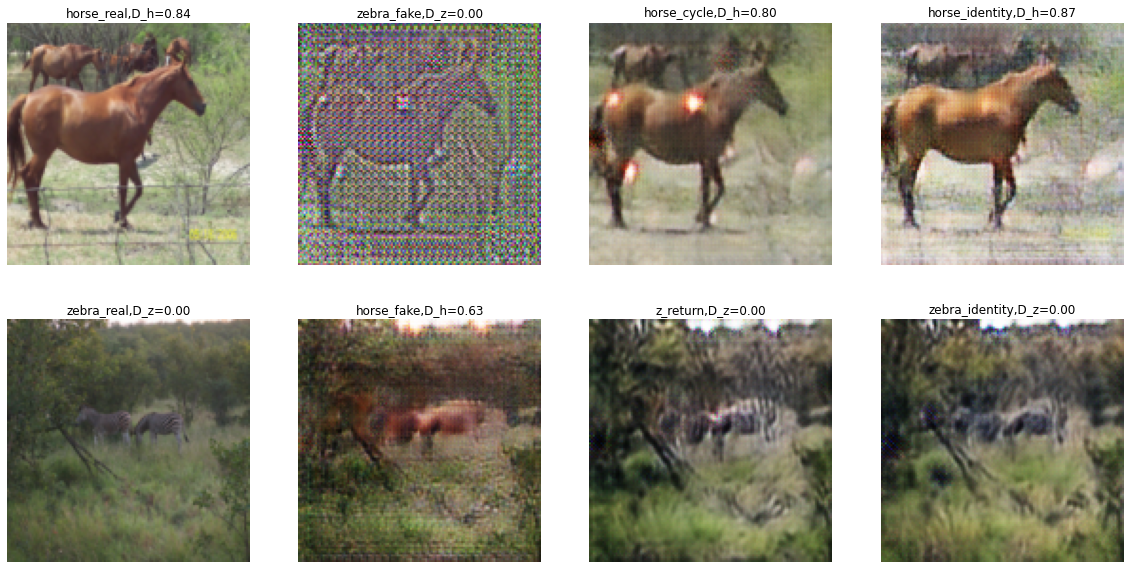

In [ ]:
plt.figure(figsize = (20, 10))
subplots = [plt.subplot(2, 4, k+1) for k in range(8)] 
P = torch.sigmoid

horse, zebra = next(iter(test_loader))
horse = horse.to(device)
zebra = zebra.to(device)

z_fake = G_h2z(horse)
h_fake = G_z2h(zebra)
z_return = G_h2z(h_fake)
h_return = G_z2h(z_fake)
z_identity = G_h2z(zebra)
h_identity = G_z2h(horse)

with torch.no_grad():
  subplots[0].imshow(horse.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)      # permute : 维度变换
  subplots[0].set_title("horse_real,D_h=%.2f" % P(D_h(horse)).max().cpu().item())
  # in tensor, it is [c,w,h], use permuter(1,2,0) to change it into [w,h,c] which is the ordinary form of image

  subplots[1].imshow(z_fake.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[1].set_title("zebra_fake,D_z=%.2f" % P(D_z(z_fake)).max().cpu().item())

  subplots[2].imshow(h_return.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[2].set_title("horse_cycle,D_h=%.2f" %P(D_h(h_return)).max().cpu().item())

  subplots[3].imshow(h_identity.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[3].set_title("horse_identity,D_h=%.2f" %P(D_h(h_identity)).max().cpu().item())

  subplots[4].imshow(zebra.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[4].set_title("zebra_real,D_z=%.2f" %P(D_z(zebra)).max().cpu().item())

  subplots[5].imshow(h_fake.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[5].set_title("horse_fake,D_h=%.2f" %P(D_h(h_fake)).max().cpu().item())

  subplots[6].imshow(z_return.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[6].set_title("z_return,D_z=%.2f" %P(D_z(z_return)).max().cpu().item())

  subplots[7].imshow(z_identity.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[7].set_title("zebra_identity,D_z=%.2f" %P(D_z(z_identity)).max().cpu().item())

  for k in range(8):
    subplots[k].axis("off")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


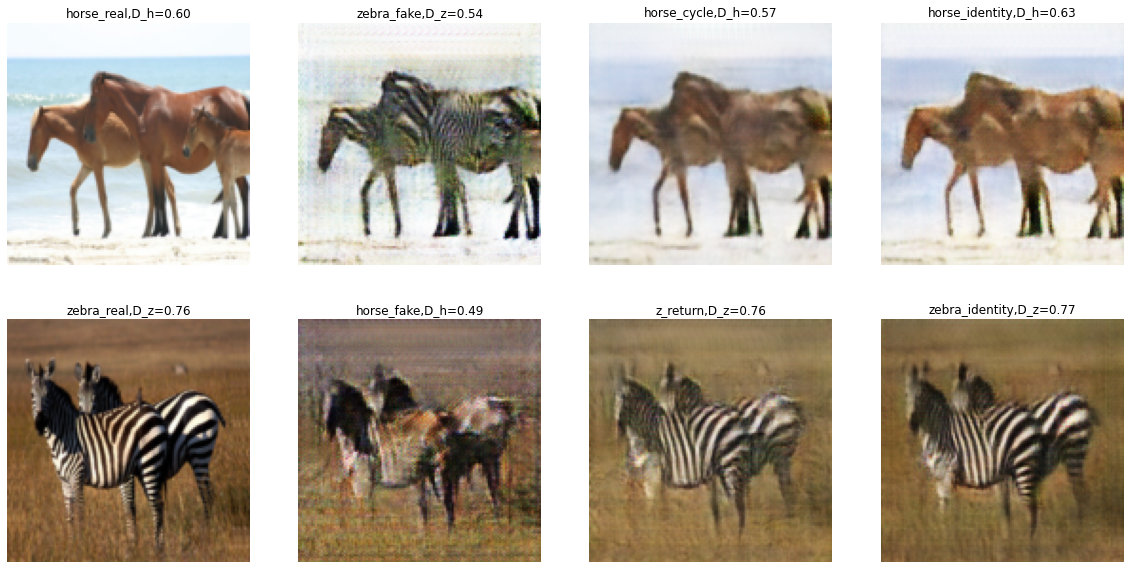

In [ ]:
plt.figure(figsize = (20, 10))
subplots = [plt.subplot(2, 4, k+1) for k in range(8)] 
P = torch.sigmoid

horse, zebra = next(iter(test_loader))
horse = horse.to(device)
zebra = zebra.to(device)

z_fake = G_h2z(horse)
h_fake = G_z2h(zebra)
z_return = G_h2z(h_fake)
h_return = G_z2h(z_fake)
z_identity = G_h2z(zebra)
h_identity = G_z2h(horse)

with torch.no_grad():
  subplots[0].imshow(horse.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)      # permute : 维度变换
  subplots[0].set_title("horse_real,D_h=%.2f" % P(D_h(horse)).max().cpu().item())
  # in tensor, it is [c,w,h], use permuter(1,2,0) to change it into [w,h,c] which is the ordinary form of image

  subplots[1].imshow(z_fake.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[1].set_title("zebra_fake,D_z=%.2f" % P(D_z(z_fake)).max().cpu().item())

  subplots[2].imshow(h_return.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[2].set_title("horse_cycle,D_h=%.2f" %P(D_h(h_return)).max().cpu().item())

  subplots[3].imshow(h_identity.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[3].set_title("horse_identity,D_h=%.2f" %P(D_h(h_identity)).max().cpu().item())

  subplots[4].imshow(zebra.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[4].set_title("zebra_real,D_z=%.2f" %P(D_z(zebra)).max().cpu().item())

  subplots[5].imshow(h_fake.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[5].set_title("horse_fake,D_h=%.2f" %P(D_h(h_fake)).max().cpu().item())

  subplots[6].imshow(z_return.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[6].set_title("z_return,D_z=%.2f" %P(D_z(z_return)).max().cpu().item())

  subplots[7].imshow(z_identity.cpu().squeeze().permute(1, 2, 0)/2 + 0.5)
  subplots[7].set_title("zebra_identity,D_z=%.2f" %P(D_z(z_identity)).max().cpu().item())

  for k in range(8):
    subplots[k].axis("off")

## Loss Figure

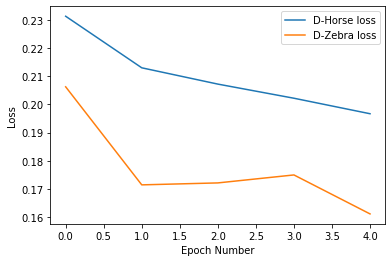

In [ ]:
plt.plot(range(5), out_dict["D_h_loss"])
plt.plot(range(5), out_dict["D_z_loss"])
plt.legend(('D-Horse loss', "D-Zebra loss"))
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

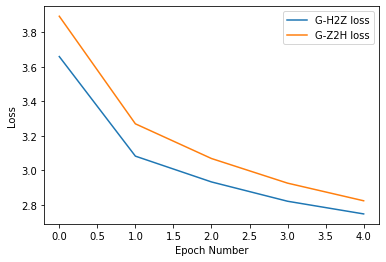

In [ ]:
plt.plot(range(5), out_dict["G_h2z_loss"])
plt.plot(range(5), out_dict["G_z2h_loss"])
plt.legend(("G-H2Z loss", "G-Z2H loss"))
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.show()

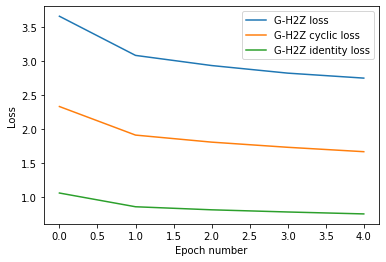

In [ ]:
plt.plot(range(5), out_dict['G_h2z_loss'])
plt.plot(range(5), out_dict['G_h2z_cyclic_loss'])
plt.plot(range(5), out_dict['G_h2z_identity_loss'])
plt.legend(('G-H2Z loss', 'G-H2Z cyclic loss', 'G-H2Z identity loss'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

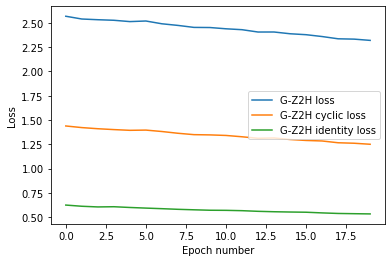

In [ ]:
plt.plot(range(20), out_dict['G_z2h_loss'])
plt.plot(range(20), out_dict['G_z2h_cyclic_loss'])
plt.plot(range(20), out_dict['G_z2h_identity_loss'])
plt.legend(('G-Z2H loss', 'G-Z2H cyclic loss', 'G-Z2H identity loss'))
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.show()

# Calculate FID

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [ ]:
import torchvision.models as models
model_inception = models.inception_v3(pretrained=True)
model_inception.fc = Identity()

In [ ]:
model_inception.to(device)
model_inception.eval();

In [ ]:
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

In [ ]:
hookF = Hook(model_inception.fc)

In [ ]:
from scipy.linalg import sqrtm

def calculate_fid(real, fake):

    real = np.array(real)
    fake = np.array(fake)
    mu1 = real.mean(axis=0)
    sigma1 = np.cov(real, rowvar=False)
    mu2 = fake.mean(axis=0)
    sigma2 = np.cov(fake, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
 
	# calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
 
	# check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

	# calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
out_real_h = []
out_fake_h = []
out_real_z = []
out_fake_z = []
for minibatch_no, (horse, zebra) in tqdm(enumerate(test_loader), total=len(test_loader)):
    # horse, zebra = next(iter(test_loader_i))
    horse = horse.to(device)
    zebra = zebra.to(device)

    # Create fake images through generators
    z_fake = G_h2z(horse) # horse to fake zebra
    h_fake = G_z2h(zebra) # zebra to fake horse

    # Pass images through the model
    with torch.no_grad():
        model_inception(horse)
        out_real_h.append(hookF.output.cpu().squeeze().numpy())
        model_inception(h_fake)
        out_fake_h.append(hookF.output.cpu().squeeze().numpy())
        model_inception(zebra)
        out_real_z.append(hookF.output.cpu().squeeze().numpy())
        model_inception(z_fake)
        out_fake_z.append(hookF.output.cpu().squeeze().numpy())

In [ ]:
calculate_fid(out_real_h, out_fake_h)

In [ ]:
calculate_fid(out_real_z, out_fake_z)